In [6]:
%pip install keras_vggface
%pip install keras_applications
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 MB 13.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [35]:
%pip install tensorflow
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 28.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 kB 28.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import keras
keras.__version__

# keras.engine.topology deprecated -- need to replace source code
filepath = "/Users/chrissy/opt/anaconda3/envs/py39/lib/python3.9/site-packages/keras_vggface/models.py" # replace filepath as necessary! 
text = open(filepath).read()
open(filepath, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

20951

### Pull VGGFace ResNet50 Pretrained Weights 

ResNet50 is trained on VGGFace2 Dataset

In [2]:
from keras_vggface.vggface import VGGFace
model = VGGFace(model='resnet50')

2022-12-05 09:41:00.032337: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Begin Transfer Learning!

We reuse the feature extraction of images thanks to the ResNet50 pretrained model weights, but retrain the classifier on six new faces of characters from _The Office_: 
- Angela 
- Dwight
- Jim 
- Kevin
- Michael
- Pam

Notice that by adding in more folders of character faces, we can easily extend this to more than just these main six characters. 

### Preprocessing Training Images

We want to extract the faces (i.e. zoom/crop to only faces) so that only the faces are used for training. That is, 
1. Iterate through all the images in the folders and extract the face in the image using OpenCV's Haar cascade.
2. Resize the extracted face to the size required by VGGFace16: 224x224 pixels.
3. Replace the original image with the extracted face.


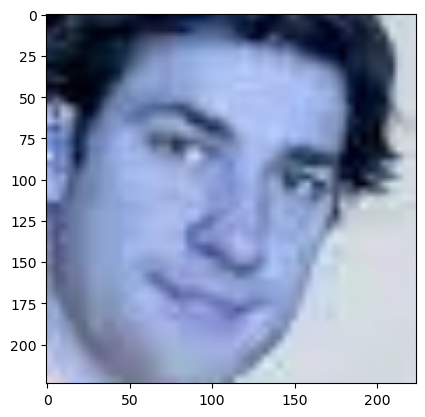

In [33]:
import cv2
import os
import pickle
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

headshots_folder_name = '../Data/characters/train'

img = Image.open('../Data/characters/train/Jim/0 10.22.12 AM.png')
im_array = np.asarray(img)
plt.imshow(img)
plt.show()


---Photo skipped---

---Photo skipped---



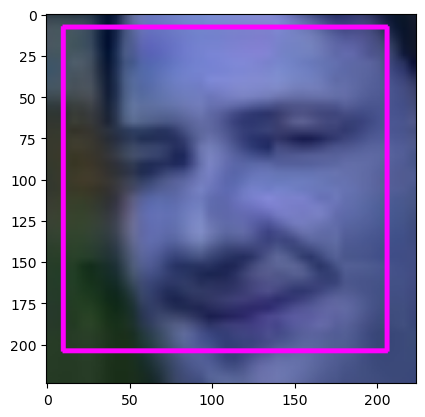

In [28]:
# dimension of images
image_width = 224
image_height = 224

# for detecting faces
facecascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# set the directory containing the images
images_dir = os.path.join(".", headshots_folder_name)

current_id = 0
label_ids = {}

# iterates through all the files in each subdirectories
for root, _, files in os.walk(images_dir):
    for file in files:
        if file.endswith("png") or file.endswith("jpg") or file.endswith("jpeg"):
            # path of the image
            path = os.path.join(root, file)
            # print(path)
            continue

        # get the label name (name of the person)
        label = os.path.basename(root).replace(" ", ".").lower()

        # add the label (key) and its number (value)
        if not label in label_ids:
            label_ids[label] = current_id
            current_id += 1

        # load the image
        imgtest = cv2.imread(path, cv2.IMREAD_COLOR)
        image_array = np.array(imgtest, "uint8")

        # get the faces detected in the image
        faces = facecascade.detectMultiScale(imgtest,
            scaleFactor=1.1, minNeighbors=5)

        # if not exactly 1 face is detected, skip this photo
        if len(faces) != 1:
            print(f'---Photo skipped---\n')
            # remove the original image
            os.remove(path)
            continue

        # save the detected face(s) and associate
        # them with the label
        for (x_, y_, w, h) in faces:

            # draw the face detected
            face_detect = cv2.rectangle(imgtest,
                    (x_, y_),
                    (x_+w, y_+h),
                    (255, 0, 255), 2)
            plt.imshow(face_detect)
            # plt.show() 

            # resize the detected face to 224x224
            size = (image_width, image_height)

            # detected face region
            roi = image_array[y_: y_ + h, x_: x_ + w]

            # resize the detected head to target size
            resized_image = cv2.resize(roi, size)
            image_array = np.array(resized_image, "uint8")

            # remove the original image
            os.remove(path)

            # replace the image with only the face
            im = Image.fromarray(image_array)
            im.save(path)


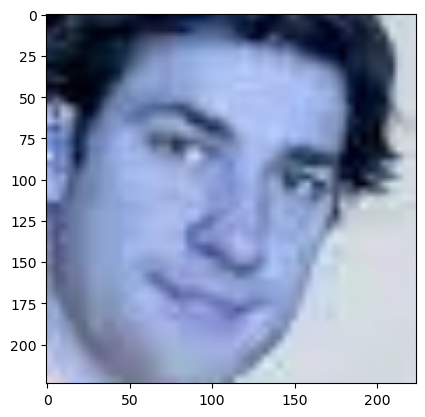

In [34]:
img = Image.open('../Data/characters/train/Jim/0 10.22.12 AM.png')
im_array = np.asarray(img)
plt.imshow(img)
plt.show()

### Import Libraries

In [37]:
import os
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

### Augment Training Data

In [39]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    headshots_folder_name, 
    target_size=(224,224), 
    color_mode='rgb', 
    batch_size=32, 
    class_mode='categorical', 
    shuffle=True
)

Found 932 images belonging to 6 classes.


In [42]:
train_generator.class_indices.values()
# dict_values([0, 1, 2])

dict_values([0, 1, 2, 3, 4, 5])

In [43]:
NO_CLASSES = len(train_generator.class_indices.values())

### Build the Model

In [44]:
base_model = VGGFace(
    include_top=False,
    model='resnet50',
    input_shape=(224, 224, 3)
)
base_model.summary()
print(len(base_model.layers))
# 174 layers after excluding the last few layers

94694792/94694792 [==============================] - 3s 0us/step
Model: "vggface_resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)           

In [45]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)

# final layer with softmax activation
preds = Dense(NO_CLASSES, activation='softmax')(x)

In [52]:
model = keras.Sequential([
    base_model,
    GlobalAveragePooling2D(), 
    Dense(1024, activation='relu'), 
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    # final layer with softmax activation
    Dense(NO_CLASSES, activation='softmax') 
])

In [53]:
# don't train the first 174 layers - 0..173
for layer in model.layers[:len(base_model.layers)]:
    layer.trainable = False

# train the rest of the layers - 174 onwards
for layer in model.layers[len(base_model.layers):]:
    layer.trainable = True

model.summary()
print(len(model.layers))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vggface_resnet50 (Functiona  (None, 1, 1, 2048)       23561152  
 l)                                                              
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_9 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dense_11 (Dense)            (None, 6)                

### Compile and Train the Model

In [54]:
model.compile(optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [57]:
model.fit(train_generator,
  batch_size = 1,
  verbose = 1,
  epochs = 20)

Epoch 1/20
30/30 [==============================] - 88s 3s/step - loss: 1.7920 - accuracy: 0.1524
Epoch 2/20
30/30 [==============================] - 85s 3s/step - loss: 1.7920 - accuracy: 0.1524
Epoch 3/20
30/30 [==============================] - 86s 3s/step - loss: 1.7920 - accuracy: 0.1524
Epoch 4/20
30/30 [==============================] - 88s 3s/step - loss: 1.7920 - accuracy: 0.1524
Epoch 5/20
30/30 [==============================] - 89s 3s/step - loss: 1.7920 - accuracy: 0.1524


KeyboardInterrupt: 